# MULTIGRIS ISM applications
## SFR determination (SFGX context)

<font color=red>For best performance, it is advised to execute MULTIGRIS in the shell, as explained in the README. This notebook is just a way to illustrate a workflow. </font>

***
This notebook presents some examples of ISM applications with MULTIGRIS. <font color=red>Make sure to check the general notebooks on how to run the programs beforehand!</font>

We'll also take the occasion to use various plots and inference options. 

The applications will use the following Cloudy grid (Ferland et al. [2017](https://ui.adsabs.harvard.edu/abs/2017RMxAA..53..385F/abstract)):
- SFGX (star-forming galaxies with X-ray component; Ramambason et al. [2022](https://ui.adsabs.harvard.edu/abs/2022A%26A...667A..35R/abstract))

The various notebooks use some specific terms described in the file TERMS.org. 
***

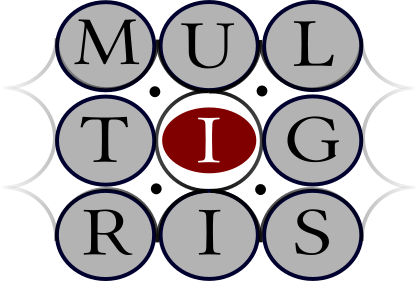

In [1]:
%load_ext autoreload
%autoreload 2
from wand.image import Image as WImage #this is to view PDFs
from IPython.display import Image
Image(filename='../Images/logo.png')

## Table of contents:
* [Estimate Q(H) or intrinsic H-alpha to get SFR](#app5)

## Imports and settings
***

In [2]:
import os 

import sys
sys.path.append('../') 

#arviz to read the PyMC3 trace
import arviz as az

import numpy as np
import matplotlib.pyplot as plt

#imports to make input files
import importlib
import Library.lib_input
importlib.reload(Library.lib_input)
from Library.lib_input import *

#import the main MULTIGRIS scripts
import mgris_search, mgris_process, mgris_post_process, mgris_compare

#may need to run this if the script is interrupted
from Library.lib_main import closelogfiles

# global parameters
from rcparams import rcParams

#to read the grid
import pandas as pd

#this is the input filename we'll use throughout, it will be automatically copied in the output directories each run
os.makedirs('./Runs/ISM_applications', exist_ok=True)
inputfile = './Runs/ISM_applications/input.txt' 

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
if rcParams['inference_backend']=='gpu':
    import jax
    jax.clear_caches()

Checking path in case several copies exist

In [4]:
mgris_search.__file__

'/local/home/vleboute/work/MULTIGRIS/mgris/mgris_search.py'

## Estimate intrinsic H-alpha or Q(H) to get SFR <a class="anchor" id="app5"></a>
***

- SFR is not a primary parameter in BOND or SFGX and it's not a secondary parameter either in the latter, but we can calculate the SFR using the intrinsic luminosity of some reference tracers, such as H-alpha, TIR, or Q(H).
- We use the SFGX grid because we wanna get the right luminosity. SFGX uses a reference stellar cluster luminosity of $10^9$ L$_\odot$. Models are then scaled up or down. 
- We will use the post-processing script this time to predict some secondary tracers/parameters: intrinsic (no extinction) H-alpha & TIR (which are not used as constraints) and Q0 (number of ionizing photons per second; which is not used for inference). 
- Since we need TIR, we wanna use the IR lines arising in the neutral gas, so we include [CII] and [OI] lines and we relax the radiation-bounded criteria to allow the models to probe any cloud depth. 
- Since we have many parameters, we increase the number of samples (now's the time to go grab some bread... you may even have time to make it yourself).
- For this test we'll use again the dwarf galaxy Haro 11.

Here we use fluxes and uncertainties in log scale. Note that this is not well adapted to lines that are barely detected (a linear scale should be used instead). 

In [5]:
params = get_params()
params['context'].value = './Contexts/mgris_sfgx'
output_directory = './Runs/ISM_applications/SFR/'
params['output'].value = output_directory
params['USE configuration'].value = '1C2S'
params['select'].value = ['Z_dust [0,0]'] 
params['BEGIN observations'].value = '''O388.3323m 42.242 0.007 0.007
N357.3238m 41.458 0.012 0.013
N2121.767m 40.552 0.033 0.036
Ne315.5509m 42.088 0.075 0.09
Ne212.8101m 41.548 0.055 0.063
S410.5076m 41.732 0.008 0.008
S318.7078m 41.738 0.054 0.061
S333.4704m 41.843 0.019 0.019
Ar26.98337m 40.603 0.12 0.167
Ar38.98898m 41.052 0.058 0.067
Ar321.8253m <39.926 nan nan
H112.3684m 40.372 0.074 0.089
N2205.244m 40.376 0.083 0.102
O163.1679m 41.815 0.008 0.008
C2157.636m 41.823 0.005 0.005
O1145.495m 40.705 0.029 0.032
'''
#we add a minimum 25% uncertainty
params['BEGIN observations'].extras = {'scale_factor': 0, 
                                       'delta_add': 0.1, 
                                       'scale': 'log',
                                       'delta_ref': 0.2} #delta_ref is required if we have upper limits in log 
params['use_scaling'].value = "'all'"
params['obs_to_predict'].value = ['H16562.81A', 'LTIR500.500m']
params['secondary_parameters'].value = ['Q0']
make_input(params, inputfile)

In [7]:
if rcParams['inference_backend']=='gpu':
    nsamples_per_job = 150
else:
    nsamples_per_job = 100
    
closelogfiles() #in case run was interrupted
mgris_search.main(args=mgris_search.args(inputfile=inputfile, order=0, nsamples_per_job=nsamples_per_job))







       ┍ M U L ┑
       ┝ T I G ┥
       ┕ R I S ┙






     ┍           ┑
     ┝ INFERENCE ┥
     ┕           ┙






Thanks for using MULTIGRIS.
Please make sure to check the README file, the notebooks, and the publication (https://ui.adsabs.harvard.edu/abs/2022A%26A...667A..34L/abstract).







▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓
▓ READING INPUT PARAMETERS ▓
▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓


-- Using pre-defined configuration 1C2S

    ┍========================================┑
    ┝========= MULTIGRIS summary ============┥
    ┝========================================┙
    ┝ git version & date:
    ┝ - 1a38371 (2024-09-06 08:20:37 +0200)
    ┝ - 1a38371
    ┝ git submodules:
    ┝ - 'Contexts/mgris_bond': 474a7c3, 'Contexts/mgris_loc': 78805da, 'Contexts/mgris_sfgx': dcd6f15 
    ┝========================================
    ┝ PyMC version  : 5.16.2
    ┝ Tensor library: pytensor
    ┝ - Compile directory:
    ┝   - /tmp/pytensor.NOBACKUP
    ┝ - Precision: float32
    ┕=============

[16  3  8  5  5  8  4  4 17]
-> [16  1  8  5  5  8  4  4 17]
[16  1  8  5  5  8  4  4 17]


n 0: single value (nearest neighbor grid interpolation)


-> [16  1  1  5  5  8  4  4 17]
[16  1  1  5  5  8  4  4 17]


u 0: single value (nearest neighbor grid interpolation)


-> [16  1  1  1  5  8  4  4 17]
[16  1  1  1  5  8  4  4 17]


Z 0: single value (nearest neighbor grid interpolation)


-> [16  1  1  1  1  8  4  4 17]
[16  1  1  1  1  8  4  4 17]


Lx 0: single value (nearest neighbor grid interpolation)


-> [16  1  1  1  1  1  4  4 17]
[16  1  1  1  1  1  4  4 17]


Tx 0: single value (nearest neighbor grid interpolation)


-> [16  1  1  1  1  1  1  4 17]
[16  1  1  1  1  1  1  4 17]


cut 0: single value (nearest neighbor grid interpolation)


-> [16  1  1  1  1  1  1  1 17]
[16  1  1  1  1  1  1  1 17]


lum 1: single value (nearest neighbor grid interpolation)
age 1: single value (nearest neighbor grid interpolation)
n 1: single value (nearest neighbor grid interpolation)


-> [16  1  1  1  1  1  1  1  1]
[16  3  8  5  5  8  4  4 17]
-> [16  1  8  5  5  8  4  4 17]
[16  1  8  5  5  8  4  4 17]
-> [16  1  1  5  5  8  4  4 17]


u 1: single value (nearest neighbor grid interpolation)


[16  1  1  5  5  8  4  4 17]
-> [16  1  1  1  5  8  4  4 17]
[16  1  1  1  5  8  4  4 17]
-> [16  1  1  1  1  8  4  4 17]


Z 1: single value (nearest neighbor grid interpolation)


[16  1  1  1  1  8  4  4 17]


Lx 1: single value (nearest neighbor grid interpolation)


-> [16  1  1  1  1  1  4  4 17]
[16  1  1  1  1  1  4  4 17]


Tx 1: single value (nearest neighbor grid interpolation)


-> [16  1  1  1  1  1  1  4 17]
[16  1  1  1  1  1  1  4 17]


cut 1: single value (nearest neighbor grid interpolation)


-> [16  1  1  1  1  1  1  1 17]
[16  1  1  1  1  1  1  1 17]
-> [16  1  1  1  1  1  1  1  1]



Calculating prior predictive sample...
--------------------------------------
Sampling: [idx_Lx_0, idx_Tx_0, idx_Z_0, idx_age_0, idx_cut_0, idx_cut_1, idx_lum_0, idx_n_0, idx_n_1, idx_u_0, idx_u_1, scale, w]
Sampling: [idx_Lx_0, idx_Tx_0, idx_Z_0, idx_age_0, idx_cut_0, idx_cut_1, idx_lum_0, idx_n_0, idx_n_1, idx_u_0, idx_u_1, scale, w]
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
                  mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
idx_Lx_0         1.455  0.805   0.202    2.882      0.035    0.025     530.0   
idx_Lx_1         1.455  0.805   0.202    2.882      0.035    0.025     530.0   
idx_Tx_0         1.482  0.817   0.155    2.878      0.046    0.032     325.0   
idx_Tx_1         1.482  0.817   0.155    2.878      0.046    0.032     325.0   
idx_Z_0          3.390  1.939   0.019    6.495      0.084    0.061     561.0   
idx_Z_1          3.390  1.939   0.019    6.495      0.084    0.061     561.0   


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details

✨
✨✨
✨✨✨✨✨
✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨
✨✨✨✨✨
✨✨
✨
✨✨
✨✨✨✨
✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨ INFERENCE END
✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨
✨✨✨✨
✨✨
✨
Inference ended     : 2024-09-06 17:58:24.082693
Time used           : 16.5 min.
Sampling time used  :  15.30 min.
Garbage collection thresholds : (700, 10, 10)
Garbage collector: collected 1667942 objects.

▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓
▓ RESULTS AND VERIFICATIONS ▓
▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓


                         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
idx_Lx_0                

In [8]:
closelogfiles() #in case run was interrupted
mgris_process.main(args=mgris_process.args(inputfile=inputfile))







       ┍ M U L ┑
       ┝ T I G ┥
       ┕ R I S ┙






     ┍            ┑
     ┝ PROCESSING ┥
     ┕            ┙






Thanks for using MULTIGRIS.
Please make sure to check the README file, the notebooks, and the publication (https://ui.adsabs.harvard.edu/abs/2022A%26A...667A..34L/abstract).

▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓
▓ READING INFERENCE DATA ▓
▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓


-- Using pre-defined configuration 1C2S







    ┍========================================┑
    ┝=========== System summary =============┥
    ┝========================================┙
    ┝ Date/time:
    ┝ - 06/09/2024 17:58:27
    ┕========================================┙
   







    ┍========================================┑
    ┝============= Run summary ==============┥
    ┝========================================┙
    ┝ - input file         : ./Runs/ISM_applications/input.txt
    ┝ - output directory   : ./Runs/ISM_applications/SFR/
    ┕========================================┙
    
List of 

In [9]:
%cat $output_directory/results.txt


            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
idx_Lx_0   1.989  0.460   1.243    2.811      0.042    0.030     136.0     159.0   1.04
idx_Lx_1   1.989  0.460   1.243    2.811      0.042    0.030     136.0     159.0   1.04
idx_Tx_0   2.043  0.251   1.583    2.409      0.016    0.011     234.0     192.0   1.05
idx_Tx_1   2.043  0.251   1.583    2.409      0.016    0.011     234.0     192.0   1.05
idx_Z_0    5.284  0.507   4.357    6.141      0.045    0.032      92.0     203.0   1.04
idx_Z_1    5.284  0.507   4.357    6.141      0.045    0.032      92.0     203.0   1.04
idx_age_0  3.828  1.661   0.782    6.168      0.260    0.185      42.0      29.0   1.08
idx_age_1  3.828  1.661   0.782    6.168      0.260    0.185      42.0      29.0   1.08
idx_cut_0  4.336  1.218   2.364    6.759      0.088    0.063     195.0     175.0   1.01
idx_cut_1  6.499  1.063   4.854    8.227      0.078    0.055     182.0     170.0   1.02
idx_lum_0  0.912  0.334   0.245

In [10]:
closelogfiles() #in case run was interrupted
mgris_post_process.main(args=mgris_post_process.args(inputfile=inputfile))







          ┍ M U L ┑
          ┝ T I G ┥
          ┕ R I S ┙






     ┍                 ┑
     ┝ POST-PROCESSING ┥
     ┕                 ┙






Thanks for using MULTIGRIS.
Please make sure to check the README file, the notebooks, and the publication (https://ui.adsabs.harvard.edu/abs/2022A%26A...667A..34L/abstract).







    ┍========================================┑
    ┝=========== System summary =============┥
    ┝========================================┙
    ┝ Date/time:
    ┝ - 06/09/2024 17:59:07
    ┕========================================┙
   
-- Using pre-defined configuration 1C2S

    Run summary
    - input file         : ./Runs/ISM_applications/input.txt
    - output directory   : ./Runs/ISM_applications/SFR/
    
Loading multi-trace...
Reading post-processing file ['post_processing_all_cutAv.fth', '#model_number']
Reading Feather file... /local/home/vleboute/work/MULTIGRIS/mgris/Contexts/mgris_sfgx/Grids/model_grid.fth (run pre-processing script if the latter

---

Expected L(H-alpha) is 42.45 (Schmitt et al. [2006](https://ui.adsabs.harvard.edu/abs/2006ApJ...643..173S/abstract); Rémy-Ruyer et al. [2015](https://ui.adsabs.harvard.edu/abs/2015A&A...573C...1R/abstract)), we find here:

In [11]:
trace = az.from_netcdf(output_directory+'trace_post-process.netCDF')
float(trace.posterior['H16562.81A'].mean().data)

42.70646667480469

---

Expected L(TIR) is 44.88 ($10^{11.3}$L$_\odot$; Rémy-Ruyer et al. [2015](https://ui.adsabs.harvard.edu/abs/2015A&A...573C...1R/abstract)), we find here:

In [12]:
float(trace.posterior['LTIR500.500m'].mean().data)

44.814449310302734

---

Now we can just use the SFR-L(H-alpha & TIR) calibration (Kennicutt et al. [2009](https://ned.ipac.caltech.edu/level5/Sept12/Calzetti/Calzetti1_2.html)) we get in M$_\odot$ yr$^{-1}$:

In [13]:
5.5e-42*(10**float(trace.posterior['H16562.81A'].mean().data)+0.0024*10**float(trace.posterior['LTIR500.500m'].mean().data))

36.58921636844602

SFR from Q(H) is, in M$_\odot$ yr$^{-1}$:

In [14]:
7.4e-54*10**(float(trace.posterior['Q0'].mean().data))

33.726612048894765

Measured SFR from H-alpha+TIR in Rémy-Ruyer et al. ([2015](https://ui.adsabs.harvard.edu/abs/2015A&A...573C...1R/abstract)): 

$\approx25 {\rm M}_\odot {\rm yr}^{-1}$